# NLP FINAL Project

### Importing Packages

In [1]:
import numpy as np 
import pandas as pd
import string 
import nltk
import re
from bs4 import BeautifulSoup
import requests
from string import punctuation
stopword = nltk.corpus.stopwords.words('english')
from matplotlib.pyplot import subplot
from matplotlib import pyplot as plt
from matplotlib.pyplot import bar
import itertools

from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support

wn = nltk.WordNetLemmatizer()
le = preprocessing.LabelEncoder()
C_vec = CountVectorizer()

import wnaffect
import emotion
from emotion import Emotion 
from wnaffect import WNAffect

wna = WNAffect('wordnet-1.6/', 'wn-domains-3.2/')

### Extracting Lyrics from Data

In [ ]:
url = data.iloc[:,2]
lyric_list = []
for URL in url:
    page = requests.get(URL)
    html = BeautifulSoup(page.text, "html.parser") # Extract the page's HTML as a string

    # Scrape the song lyrics from the HTML
    lyrics = html.find("div", class_="lyrics").get_text()
    lyric_list.append(lyrics)
%store lyric_list

In [2]:
%store -r lyric_list
# print(len(lyric_list))

2022


# PROJECT CODE

### Importing File

In [3]:
data = pd.read_csv('final_song_data.csv',delimiter=',',header =None)
artist_name = data.iloc[:,0]
song_name = data.iloc[:,1]
data_set = [list(data_row) for data_row in zip(artist_name,song_name,lyric_list)]
labels = le.fit_transform(data.iloc[:,3])
n_classes=len(data.iloc[:,3].unique())

### Pre-Processing Function for Train and Test

In [4]:
def process_features(data_set):
    
    lyric_list_new = []
    baseline_lyric = []
    artist_name_new = []
    song_name_new = []
    chorus_list = []
    verse_list = []
    bridge_list = []
    hook_list = []
    intro_list = []
    outro_list = []
    song_length = []
    for dat in data_set:
        s = dat[2]
        chorus_list.append(len(re.findall('\[Chorus', s)))
        verse_list.append(len(re.findall('\[Verse', s)))
        hook_list.append(len(re.findall('\[Hook', s)))
        bridge_list.append(len(re.findall('\[Bridge', s)))
        intro_list.append(len(re.findall('\[Intro', s)))
        outro_list.append(len(re.findall('\[Outro', s)))

        v = s.split("\n")
        song_length.append(len(v))
        for i in v:
            d = re.sub("^\[(.*)]","",i)
            v[v.index(i)] = d
        lyric_list_new.append("\n".join(v))
        baseline_lyric.append(s)
        
        artist_name_new.append(dat[0])
        song_name_new.append(dat[1])

   
    for element in range(1,len(lyric_list_new)): 
        
        #Baseline
        baseline_lyric[element] =lyric_list_new[element].replace("'"," ")
        baseline_lyric[element] = re.sub(r'[^\w\s]','',lyric_list_new[element])
        emo_list = []
        token = nltk.word_tokenize(lyric_list_new[element])
        tagged = nltk.pos_tag(token)
        tags = [x[1] for x in tagged]
        for i in range(0,len(token)):
            emo = wna.get_emotion(token[i], tags[i])
            if emo is not None:
                emo_list.append(str(emo))
        tb = " ".join([word for word in emo_list]) 
        baseline_lyric[element]=tb
        
        #LYRICS
        lyric_list_new[element] =lyric_list_new[element].replace("'"," ")
        lyric_list_new[element] = re.sub(r'[^\w\s]','',lyric_list_new[element])
        lyric_list_new[element] = nltk.word_tokenize(lyric_list_new[element])
        not_stopword_list = [word.lower() for word in lyric_list_new[element] if word.lower() not in stopword]
        t = " ".join([wn.lemmatize(word) for word in not_stopword_list])
        lyric_list_new[element]=t
        
        #ARTIST
        artist_name_new[element] =artist_name_new[element].replace(",","")
        artist_name_new[element] =artist_name_new[element].replace("&","")

        
        #SONG TITLE
        song_name_new[element] =song_name_new[element].replace("'"," ")
        song_name_new[element] = re.sub(r'[^\w\s]','',song_name_new[element])
        song_name_new[element] = nltk.word_tokenize(song_name_new[element])
        not_stopword_list = [word.lower() for word in song_name_new[element] if word.lower() not in stopword]
        t = " ".join([wn.lemmatize(word) for word in not_stopword_list])
        song_name_new[element]=t
        
    data_set_new = [artist_name_new,song_name_new,lyric_list_new,baseline_lyric]
    lyric_all = np.vstack((np.array(chorus_list),np.array(verse_list),np.array(bridge_list),np.array(hook_list),np.array(intro_list),np.array(outro_list),np.array(song_length)))
    lyric_all = np.transpose(lyric_all)
    return data_set_new,lyric_all

### Train-Test split

In [5]:
x_train, x_test, y_train, y_test = train_test_split(data_set,labels, train_size=0.8,test_size = 0.2)

#Training Set 
dataset_train_sub,feat_add_train = process_features(x_train)
artist_train_sub = dataset_train_sub[0]
song_title_train_sub = dataset_train_sub[1]
lyric_train_sub = dataset_train_sub[2]
baseline_train_sub = dataset_train_sub[3]
lyric_train_label = y_train


#Test set 
dataset_test_sub,feat_add_test = process_features(x_test)
artist_test_sub = dataset_test_sub[0]
song_title_test_sub = dataset_test_sub[1]
lyric_test_sub = dataset_test_sub[2]
baseline_test_sub = dataset_test_sub[3]
lyric_test_label = y_test

### Feature Extraction
##### Bag Of Words Approach

In [6]:
#FEATURE EXTRACTION
C_vec = CountVectorizer(max_df = 0.5,min_df = 2,ngram_range = (1,2))
trainX1 = C_vec.fit_transform(lyric_train_sub).toarray()
testX1 = C_vec.transform(lyric_test_sub).toarray()

C_vec = CountVectorizer(ngram_range = (1,3))
trainX2 = C_vec.fit_transform(artist_train_sub).toarray()
testX2 = C_vec.transform(artist_test_sub).toarray()

C_vec = CountVectorizer(max_df = 0.5,min_df = 2,ngram_range = (1,2))
trainX3 = C_vec.fit_transform(song_title_train_sub).toarray()
testX3 = C_vec.transform(song_title_test_sub).toarray()

C_vec = CountVectorizer()
trainX4 = C_vec.fit_transform(baseline_train_sub).toarray()
testX4 = C_vec.transform(baseline_test_sub).toarray()

lyric_train = np.hstack((trainX1,trainX2,trainX3,trainX4,feat_add_train))
lyric_test = np.hstack((testX1,testX2,testX3,testX4,feat_add_test))


#Final feature : lyric_train
# print("Train Data Shape: ",np.shape(lyric_train))
# print("Test Data Shape: ",np.shape(lyric_test))

Train Data Shape:  (1617, 44346)
Test Data Shape:  (405, 44346)


# CLASSIFIERS

### Multinomial Naive Bayes

In [7]:
n_class1=0
n_class2=0
n_class3=0

for i in lyric_train_label:
    if(i==0):
        n_class1+=1
    elif(i==1):
        n_class2+=1
    else:
        n_class3+=1
p1 = n_class1/(n_class1+n_class2+n_class3)
p2 = n_class2/(n_class1+n_class2+n_class3)
p3 = n_class3/(n_class1+n_class2+n_class3)
p = np.array([p1,p2,p3])
nb_g = MultinomialNB(class_prior = p)

### Support Vector Machines

In [8]:
parameters_svm = {'kernel':('linear','rbf'),'C':[1,10]}
svm = SVC()

### Random Forest

In [9]:
n_est = np.arange(1,31,1)
parameters_rf = {'n_estimators':n_est,'max_depth':[4,20,80,None]}
rfc = RandomForestClassifier()

### Logistical Regression

In [10]:
parameter_lr = {'C': [0.001,0.01,1,100,1000],'penalty':('l1','l2')}
lr = LogisticRegression(multi_class = 'ovr')

In [11]:
models = [nb_g,svm,rfc,lr]
parameters = [p,parameters_svm,parameters_rf,parameter_lr]
model_name = ['Naive Bayes','SVM','Random Forest','Logistical Regression']

### Classifiers Implementation and Evaluation

Naive Bayes


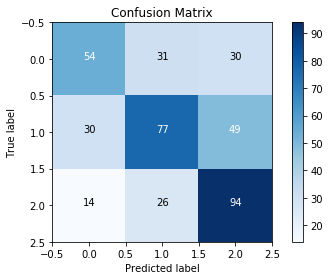

             precision    recall  f1-score   support

    class 0       0.55      0.47      0.51       115
    class 1       0.57      0.49      0.53       156
    class 2       0.54      0.70      0.61       134

avg / total       0.56      0.56      0.55       405

Train Accuracy:  0.9672232529375386 	 Test Accuracy:  0.5555555555555556
Train Precision:  0.9666671137145658 	 Test Precision:  0.5563332916636589
Train Recall:  0.9674539888320789 	 Test Recall:  0.5548824994314936
Train F1 Score:  0.9666705963899296 	 Test F1 Score:  0.5501515288142046

SVM


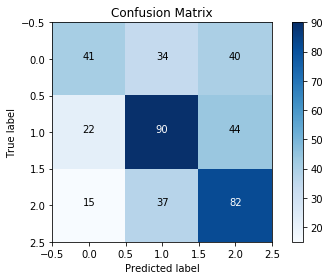

             precision    recall  f1-score   support

    class 0       0.53      0.36      0.42       115
    class 1       0.56      0.58      0.57       156
    class 2       0.49      0.61      0.55       134

avg / total       0.53      0.53      0.52       405

Train Accuracy:  0.795299938157081 	 Test Accuracy:  0.5259259259259259
Train Precision:  0.8106223192154668 	 Test Precision:  0.5262077134785358
Train Recall:  0.7843373817042804 	 Test Recall:  0.5151283715203248
Train F1 Score:  0.7883390982369353 	 Test F1 Score:  0.5131201589454969

Random Forest


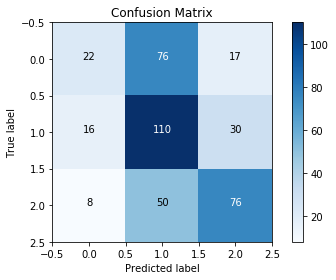

             precision    recall  f1-score   support

    class 0       0.48      0.19      0.27       115
    class 1       0.47      0.71      0.56       156
    class 2       0.62      0.57      0.59       134

avg / total       0.52      0.51      0.49       405

Train Accuracy:  0.9962894248608535 	 Test Accuracy:  0.5135802469135803
Train Precision:  0.9963854967586311 	 Test Precision:  0.5207495811140868
Train Recall:  0.9962868154365975 	 Test Recall:  0.48786557735292324
Train F1 Score:  0.9963288785390985 	 Test F1 Score:  0.4753187013259033

Logistical Regression


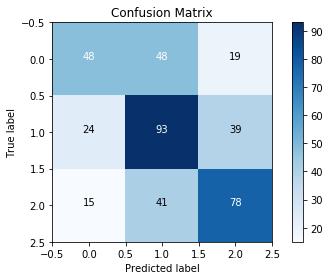

             precision    recall  f1-score   support

    class 0       0.55      0.42      0.48       115
    class 1       0.51      0.60      0.55       156
    class 2       0.57      0.58      0.58       134

avg / total       0.54      0.54      0.54       405

Train Accuracy:  0.8286951144094001 	 Test Accuracy:  0.5407407407407407
Train Precision:  0.8333608270903965 	 Test Precision:  0.545414186894917
Train Recall:  0.8176480148540449 	 Test Recall:  0.5318782342468261
Train F1 Score:  0.8227287927151128 	 Test F1 Score:  0.5344403868394729



In [12]:
Accuracy_val = []
Precision_val = []
Recall_val =[]
F1_score = []
for i in range(0,len(models)):
    print(model_name[i])
    if(i==0):
        clf = models[i]
    else:
        clf = GridSearchCV(models[i],parameters[i],cv=5)
    clf.fit(lyric_train,lyric_train_label)
    lyric_train_label_predict = clf.predict(lyric_train)
    lyric_test_label_predict = clf.predict(lyric_test)
    
    plt.figure
    #Compute Confusion Matrix
    cnf_matrix = confusion_matrix(lyric_test_label, lyric_test_label_predict)
    plt.imshow(cnf_matrix, interpolation='nearest',cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    thresh = cnf_matrix.max() / 2.
    plt.colorbar()
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], 'd'),horizontalalignment="center",color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

    plt.show()
    
    #Classification Report
    target_names = ['class 0', 'class 1', 'class 2']
    print(classification_report(lyric_test_label, lyric_test_label_predict, target_names=target_names))
    
    #Accuracy, Precision, Recall, F1score
    accuracy_train = accuracy_score(lyric_train_label,lyric_train_label_predict)
    accuracy_test = accuracy_score(lyric_test_label,lyric_test_label_predict)
    print("Train Accuracy: ",accuracy_train,'\t',"Test Accuracy: ",accuracy_test)
    
    precision_train= precision_score(lyric_train_label,lyric_train_label_predict,average = 'macro')
    precision_test =  precision_score(lyric_test_label,lyric_test_label_predict,average = 'macro')
    print("Train Precision: ",precision_train,'\t',"Test Precision: ",precision_test)
    
    recall_train= recall_score(lyric_train_label,lyric_train_label_predict,average = 'macro')
    recall_test =  recall_score(lyric_test_label,lyric_test_label_predict,average = 'macro')    
    print("Train Recall: ",recall_train,'\t',"Test Recall: ",recall_test) 
    
    f1_train = f1_score(lyric_train_label,lyric_train_label_predict,average = 'macro')
    f1_test = f1_score(lyric_test_label,lyric_test_label_predict,average = 'macro')
    print("Train F1 Score: ",f1_train,'\t',"Test F1 Score: ",f1_test)
    
    Accuracy_val.append(accuracy_test)
    Precision_val.append(precision_test)
    Recall_val.append(recall_test)
    F1_score.append(f1_test)
    print()

 
    

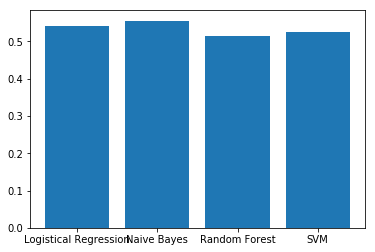

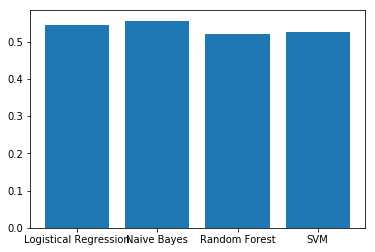

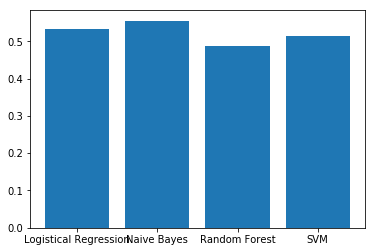

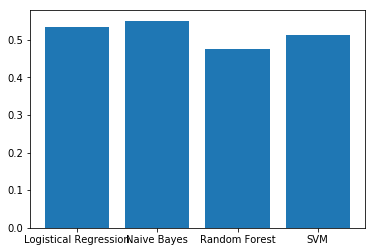

In [13]:
## Bar Graphs
plt.figure
plt.bar(model_name,Accuracy_val)
plt.show()
plt.figure
plt.bar(model_name,Precision_val)
plt.show()
plt.figure
plt.bar(model_name,Recall_val)
plt.show()
plt.figure
plt.bar(model_name,F1_score)
plt.show()